In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [44]:
X = np.load("features.npz")['a']
y = np.load("labels.npz")['a']
y = np.select([y == 1, y == 2], [0, 1], y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

print("\nTraining data samples:")
print(X_train.shape)


Training data samples:
(583, 2016)


In [45]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#y_train =  torch.from_numpy(y_train.ravel()).float()
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

print(y_train)
print(X_test)

tensor([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 

In [46]:
#Function to train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#Calling dataset class to train on X and y tensors
train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
#Function to test data
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
#Calling dataset class to test on X tensor
test_data = TestData(torch.FloatTensor(X_test))

In [47]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [48]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(2016, 256) 
        self.layer_2 = nn.Linear(256, 50)
        self.layer_out = nn.Linear(50, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(50)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


cpu
BinaryClassification(
  (layer_1): Linear(in_features=2016, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [50]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [51]:
model.train()
train_loss, valid_loss = [], []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        train_loss.append(loss.item())

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Train Loss: 0.69464 | Acc: 59.100
Epoch 002: | Train Loss: 0.52294 | Acc: 73.000
Epoch 003: | Train Loss: 0.41297 | Acc: 82.500
Epoch 004: | Train Loss: 0.34926 | Acc: 87.400
Epoch 005: | Train Loss: 0.27258 | Acc: 92.600
Epoch 006: | Train Loss: 0.20045 | Acc: 96.000
Epoch 007: | Train Loss: 0.18843 | Acc: 96.000
Epoch 008: | Train Loss: 0.12419 | Acc: 97.700
Epoch 009: | Train Loss: 0.11190 | Acc: 96.900
Epoch 010: | Train Loss: 0.10133 | Acc: 98.400
Epoch 011: | Train Loss: 0.12900 | Acc: 96.300
Epoch 012: | Train Loss: 0.13874 | Acc: 94.800
Epoch 013: | Train Loss: 0.14394 | Acc: 96.900
Epoch 014: | Train Loss: 0.11434 | Acc: 96.700
Epoch 015: | Train Loss: 0.08261 | Acc: 98.500
Epoch 016: | Train Loss: 0.10213 | Acc: 96.900
Epoch 017: | Train Loss: 0.11243 | Acc: 95.500
Epoch 018: | Train Loss: 0.10121 | Acc: 96.900
Epoch 019: | Train Loss: 0.08219 | Acc: 98.200
Epoch 020: | Train Loss: 0.07130 | Acc: 98.500
Epoch 021: | Train Loss: 0.07168 | Acc: 97.500
Epoch 022: | 

In [52]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#print(y_pred_list)    

In [53]:
model.eval()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        valid_loss.append(loss.item())
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Valid Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        

Epoch 001: | Valid Loss: 0.03710 | Acc: 99.400
Epoch 002: | Valid Loss: 0.03091 | Acc: 99.100
Epoch 003: | Valid Loss: 0.01810 | Acc: 99.600
Epoch 004: | Valid Loss: 0.00654 | Acc: 100.000
Epoch 005: | Valid Loss: 0.00568 | Acc: 100.000
Epoch 006: | Valid Loss: 0.00323 | Acc: 100.000
Epoch 007: | Valid Loss: 0.00275 | Acc: 100.000
Epoch 008: | Valid Loss: 0.00202 | Acc: 100.000
Epoch 009: | Valid Loss: 0.00169 | Acc: 100.000
Epoch 010: | Valid Loss: 0.00151 | Acc: 100.000
Epoch 011: | Valid Loss: 0.00152 | Acc: 100.000
Epoch 012: | Valid Loss: 0.00136 | Acc: 100.000
Epoch 013: | Valid Loss: 0.00128 | Acc: 100.000
Epoch 014: | Valid Loss: 0.00117 | Acc: 100.000
Epoch 015: | Valid Loss: 0.00103 | Acc: 100.000
Epoch 016: | Valid Loss: 0.00100 | Acc: 100.000
Epoch 017: | Valid Loss: 0.00092 | Acc: 100.000
Epoch 018: | Valid Loss: 0.00086 | Acc: 100.000
Epoch 019: | Valid Loss: 0.00080 | Acc: 100.000
Epoch 020: | Valid Loss: 0.00076 | Acc: 100.000
Epoch 021: | Valid Loss: 0.00075 | Acc: 100

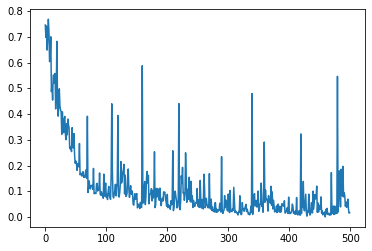

In [54]:
plt.plot(train_loss)

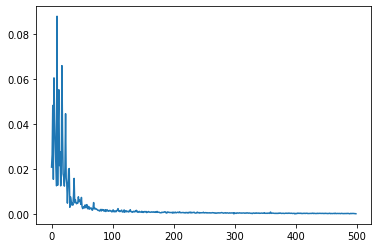

In [55]:
plt.plot(valid_loss)

In [56]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.61      0.67      0.64       132
         1.0       0.70      0.63      0.66       156

    accuracy                           0.65       288
   macro avg       0.65      0.65      0.65       288
weighted avg       0.65      0.65      0.65       288

